<br>  

## <span style='color:blue'>Section 1: Import</span>  

In [1]:
import pandas as pd
import numpy as np
import copy

from sklearn.model_selection import StratifiedKFold

from sklearn.impute import KNNImputer
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from collections import Counter

from imblearn.pipeline import Pipeline

from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.regularizers import l1
from keras.callbacks import EarlyStopping

import shap
shap.initjs()

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score

import matplotlib.pyplot as plt
import seaborn as sns

<br>  

## <span style='color:blue'>Section 2: Read, drop columns, form X_train and y_train</span>  

In [2]:
# ---------- read ----------

df_1 = pd.read_csv('../data/code_3_train.csv')

# ---------- drop ----------

print('Before drop :', df_1.shape)
df_1.drop(columns=['index',
                   'pco2', 'ph', 'basophils', 'lactic_acid', 'bmi',
                   'creatine_kinase', 'lymphocyte', 'neutrophils'], inplace=True)
print('After drop:', df_1.shape)
print('')

# ---------- form X ----------

X_train = df_1.drop(columns=['outcome'])
print('X_train :', X_train.shape)

# ---------- form y ----------

y_train = df_1['outcome']
print('y_train :', y_train.shape)
print('')
print('y_train :', np.unique(y_train, return_counts=True))
print('y_train :', Counter(y_train))
print(y_train.value_counts(normalize=True))

Before drop : (882, 51)
After drop: (882, 42)

X_train : (882, 41)
y_train : (882,)

y_train : (array([0., 1.]), array([763, 119], dtype=int64))
y_train : Counter({0.0: 763, 1.0: 119})
0.0    0.865079
1.0    0.134921
Name: outcome, dtype: float64


<br>  

## <span style='color:blue'>Section 3: Pipeline instantiate, fit, predict - Full train set</span>  

In [3]:
def nn_keras_class(layer_1, layer_2, dropout_rate, regularisation_alpha):
    model = Sequential()
    model.add(Dense(units=layer_1, activation='relu', input_dim=41))
    model.add(Dropout(rate=dropout_rate))
    model.add(Dense(units=layer_2, activation='relu', kernel_regularizer=l1(regularisation_alpha)))
    model.add(Dropout(rate=dropout_rate))
    model.add(Dense(units=1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['Recall'])
    return model

nn_keras_class_model = KerasClassifier(build_fn=nn_keras_class, epochs=100, batch_size=32, verbose=2)

### <span style='color:green'>Best hyperparameters found:</span>  
* <span style='color:green'>layer_1=5</span>  
* <span style='color:green'>layer_2=3</span>  
* <span style='color:green'>dropout_rate=0.4</span>  
* <span style='color:green'>alpha=0.1</span>  

### <span style='color:green'>Use oversample=1</span>  

In [4]:
# ---------- instantiate ----------

nn_keras_pipeline = Pipeline([
    ('knn_impute', KNNImputer(n_neighbors=5)),
    ('smote_sample', SMOTE(random_state=42)),
    ('std_scale', StandardScaler()),
    ('nn_model', nn_keras_class_model)
])

decision_boundary = 0.4

nn_keras_pipeline.set_params(smote_sample__sampling_strategy=1,
                             nn_model__layer_1=5,
                             nn_model__layer_2=3,
                             nn_model__dropout_rate=0.4,
                             nn_model__regularisation_alpha=0.1)

es = EarlyStopping(patience=3, monitor='loss')

# ---------- fit ----------

nn_keras_pipeline.fit(X_train, y_train, nn_model__callbacks=[es])

# ---------- predict ----------

y_train_predicted = (nn_keras_pipeline.predict_proba(X_train)[:,1]>=decision_boundary).astype(int)

Epoch 1/100
48/48 - 0s - loss: 1.2965 - recall: 0.6750
Epoch 2/100
48/48 - 0s - loss: 1.2082 - recall: 0.6986
Epoch 3/100
48/48 - 0s - loss: 1.1319 - recall: 0.7693
Epoch 4/100
48/48 - 0s - loss: 1.0550 - recall: 0.7837
Epoch 5/100
48/48 - 0s - loss: 0.9996 - recall: 0.8073
Epoch 6/100
48/48 - 0s - loss: 0.9497 - recall: 0.8401
Epoch 7/100
48/48 - 0s - loss: 0.9091 - recall: 0.8689
Epoch 8/100
48/48 - 0s - loss: 0.8660 - recall: 0.8820
Epoch 9/100
48/48 - 0s - loss: 0.8381 - recall: 0.9069
Epoch 10/100
48/48 - 0s - loss: 0.8169 - recall: 0.8991
Epoch 11/100
48/48 - 0s - loss: 0.7928 - recall: 0.9109
Epoch 12/100
48/48 - 0s - loss: 0.7736 - recall: 0.9096
Epoch 13/100
48/48 - 0s - loss: 0.7542 - recall: 0.9148
Epoch 14/100
48/48 - 0s - loss: 0.7340 - recall: 0.8965
Epoch 15/100
48/48 - 0s - loss: 0.7092 - recall: 0.9043
Epoch 16/100
48/48 - 0s - loss: 0.6935 - recall: 0.9227
Epoch 17/100
48/48 - 0s - loss: 0.6886 - recall: 0.9030
Epoch 18/100
48/48 - 0s - loss: 0.6913 - recall: 0.8912
E

<br>  

## <span style='color:blue'>Section 4: Model summary using SHAP</span>  

In [5]:
# ---------- select a sample from X_train to feed into SHAP ----------

X_train_sample = shap.utils.sample(X_train, nsamples=100, random_state=42)
explainer = shap.KernelExplainer(nn_keras_pipeline.predict, X_train_sample)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
4/4 - 0s


In [6]:
shap_values_sample = explainer.shap_values(X_train_sample)

  0%|          | 0/100 [00:00<?, ?it/s]

1/1 - 0s
6657/6657 - 1s
1/1 - 0s
6657/6657 - 1s
1/1 - 0s
6657/6657 - 1s
1/1 - 0s
6657/6657 - 1s
1/1 - 0s
6657/6657 - 1s
1/1 - 0s
6657/6657 - 1s
1/1 - 0s
6657/6657 - 1s
1/1 - 0s
6657/6657 - 1s
1/1 - 0s
6657/6657 - 1s
1/1 - 0s
6657/6657 - 1s
1/1 - 0s
6657/6657 - 1s
1/1 - 0s
6657/6657 - 1s
1/1 - 0s
6657/6657 - 1s
1/1 - 0s
6657/6657 - 1s
1/1 - 0s
6657/6657 - 1s
1/1 - 0s
6657/6657 - 1s
1/1 - 0s
6657/6657 - 1s
1/1 - 0s
6657/6657 - 1s
1/1 - 0s
6657/6657 - 1s
1/1 - 0s
6657/6657 - 1s
1/1 - 0s
6657/6657 - 1s
1/1 - 0s
6657/6657 - 1s
1/1 - 0s
6657/6657 - 1s
1/1 - 0s
6657/6657 - 1s
1/1 - 0s
6657/6657 - 1s
1/1 - 0s
6657/6657 - 1s
1/1 - 0s
6657/6657 - 1s
1/1 - 0s
6657/6657 - 1s
1/1 - 0s
6657/6657 - 2s
1/1 - 0s
6657/6657 - 1s
1/1 - 0s
6657/6657 - 1s
1/1 - 0s
6657/6657 - 1s
1/1 - 0s
6657/6657 - 1s
1/1 - 0s
6657/6657 - 1s
1/1 - 0s
6657/6657 - 1s
1/1 - 0s
6657/6657 - 1s
1/1 - 0s
6657/6657 - 1s
1/1 - 0s
6657/6657 - 1s
1/1 - 0s
6657/6657 - 1s
1/1 - 0s
6657/6657 - 1s
1/1 - 0s
6657/6657 - 1s
1/1 - 0s
6657/66

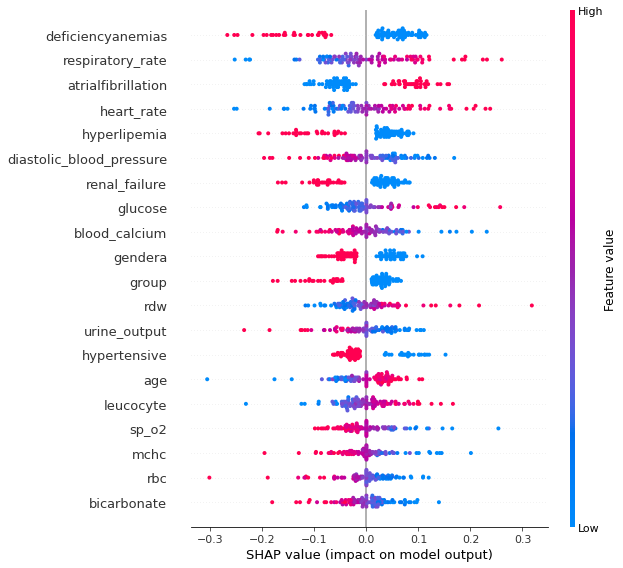

In [7]:
# ---------- class ----------

shap.summary_plot(shap_values_sample[0], X_train_sample)

<br>  

## <span style='color:blue'>Section 5: Read, drop columns, form X_test and y_test</span>  

In [8]:
# ---------- read ----------

df_2 = pd.read_csv('../data/code_3_test.csv')

# ---------- drop ----------

print('Before drop :', df_2.shape)
df_2.drop(columns=['index',
                   'pco2', 'ph', 'basophils', 'lactic_acid', 'bmi',
                   'creatine_kinase', 'lymphocyte', 'neutrophils'], inplace=True)
print('After drop:', df_2.shape)
print('')

# ---------- form X ----------

X_test = df_2.drop(columns=['outcome'])
print('X_test :', X_test.shape)

# ---------- form y ----------

y_test = df_2['outcome']
print('y_test :', y_test.shape)
print('')
print('y_test :', np.unique(y_test, return_counts=True))
print('y_test :', Counter(y_test))
print(y_test.value_counts(normalize=True))

Before drop : (294, 51)
After drop: (294, 42)

X_test : (294, 41)
y_test : (294,)

y_test : (array([0., 1.]), array([254,  40], dtype=int64))
y_test : Counter({0.0: 254, 1.0: 40})
0.0    0.863946
1.0    0.136054
Name: outcome, dtype: float64


<br>  

## <span style='color:blue'>Section 6: Pipeline predict - Full test set</span>  

In [9]:
y_test_predicted = (nn_keras_pipeline.predict_proba(X_test)[:,1]>=decision_boundary).astype(int)

10/10 - 0s


<br>  

## <span style='color:blue'>Section 7: Evaluate</span>  

In [10]:
# ---------- accuracy, recall, precision, overfit evaluation ----------

print('Train accuracy :', accuracy_score(y_train, y_train_predicted))
print('Test accuracy :', accuracy_score(y_test, y_test_predicted))
print('Overfit % = ( Test - Train ) / Train % :',
      (accuracy_score(y_test, y_test_predicted)-accuracy_score(y_train, y_train_predicted))/accuracy_score(y_train, y_train_predicted)*100)
print('')

print('Train recall :', recall_score(y_train, y_train_predicted))
print('Test recall :', recall_score(y_test, y_test_predicted))
print('Overfit % = ( Test - Train ) / Train % :',
      (recall_score(y_test, y_test_predicted)-recall_score(y_train, y_train_predicted))/recall_score(y_train, y_train_predicted)*100)
print('')

print('Train precision :', precision_score(y_train, y_train_predicted))
print('Test precision :', precision_score(y_test, y_test_predicted))
print('Overfit % = ( Test - Train ) / Train % :',
      (precision_score(y_test, y_test_predicted)-precision_score(y_train, y_train_predicted))/precision_score(y_train, y_train_predicted)*100)
print('')

Train accuracy : 0.6417233560090703
Test accuracy : 0.6156462585034014
Overfit % = ( Test - Train ) / Train % : -4.063604240282679

Train recall : 0.9243697478991597
Test recall : 0.825
Overfit % = ( Test - Train ) / Train % : -10.750000000000009

Train precision : 0.2637889688249401
Test precision : 0.23741007194244604
Overfit % = ( Test - Train ) / Train % : -10.00000000000001



In [11]:
# ---------- confusion matrix calculation ----------

tn, fp, fn, tp = confusion_matrix(y_test, y_test_predicted).ravel()
print('True positive (dead): ', tp)
print('True negative (alive): ', tn)
print('False positive (dead): ', fp)
print('False negative (alive): ', fn)
print('')

print('Accuracy :', accuracy_score(y_test, y_test_predicted))
print('')

print('Sensitivity or Recall :', recall_score(y_test, y_test_predicted))
print('')

print('Precision or Positive Predictive Value :', precision_score(y_test, y_test_predicted))
print('')

print('Specificity :', tn/(tn+fp))
print('')

print('Negative predictive value :', tn/(tn+fn))

True positive (dead):  33
True negative (alive):  148
False positive (dead):  106
False negative (alive):  7

Accuracy : 0.6156462585034014

Sensitivity or Recall : 0.825

Precision or Positive Predictive Value : 0.23741007194244604

Specificity : 0.5826771653543307

Negative predictive value : 0.9548387096774194


Text(69.0, 0.5, 'predicted')

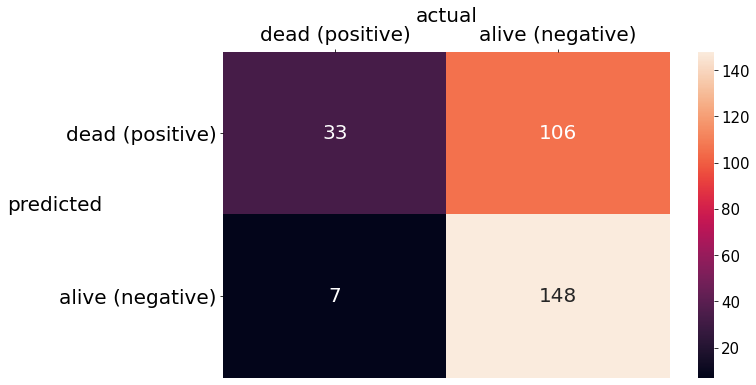

In [12]:
# ---------- confusion matrix visualisation ----------

temp_df = [[tp, fp], [fn, tn]]
temp_df = pd.DataFrame(temp_df, columns=['dead (positive)', 'alive (negative)'], index=['dead (positive)', 'alive (negative)'])
temp_df

fig, ax = plt.subplots(figsize=(10, 6))

sns.heatmap(temp_df, annot=True, fmt='d', annot_kws={'size': 20})

# Colour map labels

fig.axes[-1].tick_params(labelsize=15)

# X axis title

ax.tick_params(axis='x', labelrotation=0, which='major', labelsize=20, top=True, labeltop=True, bottom=False, labelbottom=False)
ax.xaxis.set_label_position('top')
ax.set_xlabel('actual', {'fontsize': 20})

# Y axis title

ax.tick_params(axis='y', labelrotation=0, which='major', labelsize=20, left=True, labelleft=True)
ax.set_ylabel('predicted', {'fontsize': 20, 'rotation': 'horizontal'})

10/10 - 0s

Area Under Curve (AUC) : 0.7586614173228347



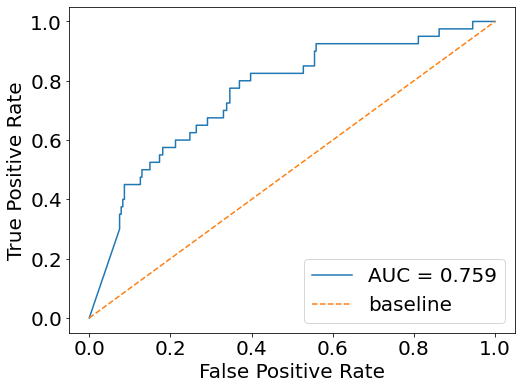

In [13]:
# ---------- area under receiver operating characteristic curve ----------

y_test_predicted_prob = nn_keras_pipeline.predict_proba(X_test)[:,1]

plt.figure(figsize=(8, 6))

fpr, tpr, _ = roc_curve(y_test, y_test_predicted_prob, drop_intermediate=False)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label='AUC = ' + str(round(roc_auc, 3)))
plt.plot([0, 1], [0, 1], label='baseline', linestyle='--')
plt.legend(loc='lower right', fontsize=20)
plt.ylabel('True Positive Rate', fontsize=20)
plt.xlabel('False Positive Rate', fontsize=20)
plt.tick_params(labelsize=20)
print('')

print('Area Under Curve (AUC) :', roc_auc_score(y_test, y_test_predicted_prob))
print('')

10/10 - 0s

Area Under Curve (AUC) : 0.41157884571668657



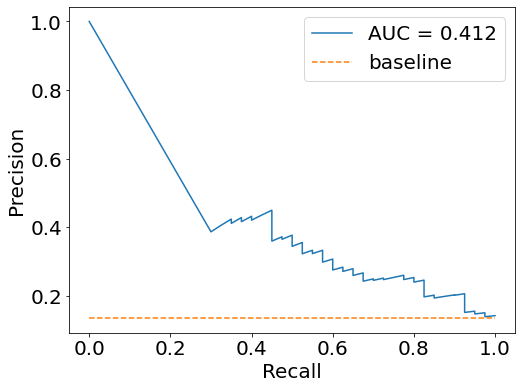

In [14]:
# ---------- area under precision recall curve ----------

y_test_predicted_prob = nn_keras_pipeline.predict_proba(X_test)[:,1]

plt.figure(figsize=(8, 6))

preci, recal, _ = precision_recall_curve(y_test, y_test_predicted_prob)
pr_auc = auc(recal, preci)

plt.plot(recal, preci, label='AUC = ' + str(round(pr_auc, 3)))
base_line = len(y_test[y_test==1]) / len(y_test)
plt.plot([0, 1], [base_line, base_line], label='baseline', linestyle='--')
plt.legend(loc='upper right', fontsize=20)
plt.ylabel('Precision', fontsize=20)
plt.xlabel('Recall', fontsize=20)
plt.tick_params(labelsize=20)
print('')

print('Area Under Curve (AUC) :', auc(recal, preci))
print('')

### <span style='color:green'>Final performance of Neural Network:</span>  
* <span style='color:green'>Recall=0.825 (overfit=-9.93%)</span>  
* <span style='color:green'>Precision=0.241 (overfit=-7.19%) (Low precision expected as recall is more important)</span>  
* <span style='color:green'>AUROC=0.762</span>  
* <span style='color:green'>AUPRC=0.496</span>  

3 Jan 2022